# Загрузка Pandas и очистка данных

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np
import warnings
import random
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor  # инструмент для создания и обучения модели
from sklearn import metrics  # инструменты для оценки точности модели
import re
from datetime import datetime
from datetime import timedelta
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
pf = PolynomialFeatures(2)
mlb = MultiLabelBinarizer()
%matplotlib inline

In [80]:
rest = pd.read_csv('C:/Users/Sergei/Downloads/main_task_new.csv')
rest.columns = [i.lower() for i in rest.columns]
rest.columns = rest.columns.str.replace(' ', '_')

__Полезные функции__

In [81]:
def first_look(df: pd.DataFrame, column: object, outlier_bounds: dict, descriptions: dict):
    '''
    Функция для осмотра переменных
    '''
    print('### ' + str(column))
    if column in list(descriptions.keys()):
        print(descriptions[column])
    if df.loc[:, col].dtypes == np.dtype('O'): # Проверка на строковый тип данных
        fig, ax = plt.subplots(figsize=(6, 5))
        sns.countplot(df.loc[:, column], ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")
    else:
        # Prepare plot data frame
        plot_df = pd.DataFrame({'Распределение': df[column]})
        if search_mistakes(df, column, outlier_bounds):
            low, high = IQR_outlier(df, column, verbose=False)
            plot_df['Распределение в границах выбросов'] = df.loc[df.loc[:,column].between(low, high)][column]
        # Draw plot
        fig, ax = plt.subplots(figsize=(7 * plot_df.shape[1], 4))
        plot_df.hist(ax=ax)
        plt.show()
        # Print misses percent
        misses = (1 - (df[column].count() / df.shape[0]))
        print('Процент пропусков: ', round(misses*100, 2), "%")


def search_mistakes(df: pd.DataFrame, column: object, outlier_bounds: dict) -> bool:
    '''
    Функция проверяет переменные на наличие ошибок в данных
    '''
    if column not in list(outlier_bounds.keys()):
        low, high = IQR_outlier(df, column, verbose=False)
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
            low,high)) & pd.notnull(df.loc[:, column])]
            print('Найдены ошибки в количестве: ', out_df.shape[0])
            if out_df.shape[0]>10:
                print('\nПервые 10:')
            display(out_df[:10])
            return True
        else:
            print('Выбросы не обнаружены')
    else:
        low, high = outlier_bounds[column][0], outlier_bounds[column][1]
        if df[column].min() < low or df[column].max() > high:
            out_df = df.loc[(~df.loc[:, column].between(
            low,high)) & pd.notnull(df.loc[:, column])]
            print('Найдены выбросы по IQR в количестве: ', out_df.shape[0])
            if out_df.shape[0]>10:
                print('\nПервые 10:')
            display(out_df[:10])
            return True
        else:
            print('Ошибки не обнаружены')

def get_boxplot(df: pd.DataFrame, column: object, ax_y='rating') -> None:
    '''
    Функция для отображения boxplot-графиков для номинативных и смешанных переменных
    '''
    fig, ax = plt.subplots(figsize = (8, 4))
    box_plot = sns.boxplot(x=column, y=ax_y, data=df,ax=ax)
    cnt = df[column].value_counts()
    medians = df.groupby([column])[ax_y].median()
    vertical_offset = df.groupby([column])[ax_y].median() * 0.12
    x=rest[column].unique()
    x = list(filter(lambda v: v==v, x))
    if df.loc[:, col].dtypes != np.dtype('O'):
        x = sorted(x)
    for xtick, ytick in zip(list(box_plot.get_xticks()), x):
        box_plot.text(xtick, medians.loc[ytick]-vertical_offset[ytick], cnt.loc[ytick],
                    horizontalalignment='center',size=15, color='w',weight='semibold')
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()



def get_stat_dif(df: pd.DataFrame, column: object, target='score') -> bool:
    '''
    Функция для проведения теста Стьюдента для номинативных и смешанных переменных
    '''
    cols = df.loc[:, column].value_counts()
    cols = cols[cols>15].index
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:
        if ttest_ind(df.loc[df.loc[:, column] == comb[0], target].dropna(),
                        df.loc[df.loc[:, column] == comb[1], target].dropna()).pvalue \
            <= 0.075/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            return True
            break

def IQR_outlier(df: pd.DataFrame, column: object, verbose: bool=True) -> tuple:
    '''
    Функция для отображения границ межквартильного размаха
    '''
    perc25 = df[column].quantile(0.25)
    perc75 = df[column].quantile(0.75)
    IQR = perc75 - perc25
    low = perc25 - 1.5*IQR
    high = perc75 + 1.5*IQR
    if verbose:
        print('25-й перцентиль: {},'.format(perc25)[:-1], '75-й перцентиль: {},'.format(perc75),
            "IQR: {}, ".format(IQR), "Границы выбросов: [{f}, {l}].".format(f=low, l=high))
    return (low, high)

def round_of_rating(number):
    """Round a number to the closest half integer.
    >>> round_of_rating(1.3)
    1.5
    >>> round_of_rating(2.6)
    2.5
    >>> round_of_rating(3.0)
    3.0
    >>> round_of_rating(4.1)
    4.0"""
    return round(number * 2) / 2

def find_IQR(Q1,Q3):
    if Q1 > Q3:
        return Q1-Q3
    else:
        return Q3-Q1

def df_without_outliers(df,column):
    Q1 = df[column].quantile(q=0.25, interpolation='midpoint')
    Q3 = df[column].quantile(q=0.75, interpolation='midpoint')
    IQR = abs(find_IQR(Q1,Q3))
    if Q1 < Q3:
        V1 = Q1 - 1.5*IQR
        V2 = Q3 + 1.5*IQR
        return df[(df[column] > V1) & (df[column] < V2)][column]
    else:
        V1 = Q1 + 1.5*IQR
        V2 = Q3 - 1.5*IQR
        return df[(df[column] < V1) & df[column] > V2][column]
    
def corr_based_replace(df, col1, col2):
    print(df[(df[col1] == 1) & (df[col2] == 1)][[col1,col2]].count())
    df.loc[((df[col1] == 1) & (df[col2] == 1)), col2] = 0
    print(df[(df[col1] == 1) & (df[col2] == 1)][[col1,col2]].count())

__restaurant_id__ — идентификационный номер ресторана / сети ресторанов;  
__city__ — город, в котором находится ресторан;                 
__cuisine_style__ — кухня или кухни, к которым можно отнести блюда, предлагаемые в ресторане;

__ranking__ — место, которое занимает данный ресторан среди всех ресторанов своего города;

__rating__ — рейтинг ресторана по данным TripAdvisor (именно это значение должна будет предсказывать модель);  
__price_range__ — диапазон цен в ресторане;                     
__number_of_reviews__ — количество отзывов о ресторане;         
__reviews__ — данные о двух отзывах, которые отображаются на сайте ресторана; 

__url_ta__ — URL страницы ресторана на TripAdvisor;              
__id_ta__ — идентификатор ресторана в базе данных TripAdvisor.   

__Обрабатываем данные__

Начнём с Cuisine Style

In [82]:
rest.cuisine_style.value_counts(dropna=False)

NaN                                                                                                             9283
['Italian']                                                                                                     1032
['French']                                                                                                       805
['Spanish']                                                                                                      695
['French', 'European']                                                                                           405
                                                                                                                ... 
['Caribbean', 'Latin', 'Venezuelan', 'South American']                                                             1
['Uzbek']                                                                                                          1
['Asian', 'Korean', 'Street Food', 'Fast Food']                 

Много сгруппированных данных, как и NaN. Выведем данные по самой частой кухне, также можно посмотреть в каких городах какая кухня распространена больше всего и заполнить пропуски этой кухней

In [83]:
# приводим данные к list
rest.cuisine_style = rest.cuisine_style.str.replace(', ', ',')
rest.cuisine_style = rest.cuisine_style.str.replace("'", '')
rest.cuisine_style = rest.cuisine_style.str[1:-1].str.split(',').tolist()

Сколько типов кухонь представлено в наборе данных?

In [84]:
cuisine_set = set()
new_cuisine = rest.cuisine_style.dropna().copy()
for i in new_cuisine:
    if len(i) > 0:
        for j in i:
            cuisine_set.add(j)
len(cuisine_set)

125

Какая кухня представлена в наибольшем количестве ресторанов? Введите название кухни без кавычек или апострофов.

In [85]:
rest_cuisine_style = rest.explode('cuisine_style')
rest_cuisine_style.cuisine_style.value_counts()

Vegetarian Friendly    11189
European               10060
Mediterranean           6277
Italian                 5964
Vegan Options           4486
                       ...  
Yunnan                     1
Burmese                    1
Latvian                    1
Salvadoran                 1
Xinjiang                   1
Name: cuisine_style, Length: 125, dtype: int64

Какое среднее количество кухонь предлагается в одном ресторане? Если в данных отсутствует информация о типах кухонь, то считайте, что в этом ресторане предлагается только один тип кухни. Ответ округлите до одного знака после запятой.

In [86]:
rest['cuisine_count'] = rest.cuisine_style.apply(lambda x: 1 if str(x) == 'nan' else len(x))


(НЕ) Уберём выбросы из cuisine_count (заменять выбросы на среднее, то MAE ухудшается)

In [87]:
IQR_outlier(rest, 'cuisine_count')

25-й перцентиль: 1.0 75-й перцентиль: 4.0, IQR: 3.0,  Границы выбросов: [-3.5, 8.5].


(-3.5, 8.5)

In [88]:
#rest_cuisine_count_mean = df_without_outliers(rest, 'cuisine_count').mean()

#rest.cuisine_count = rest.cuisine_count.apply(lambda x: rest_cuisine_count_mean if x>8.5 else x)


Какая кухня представлена в наибольшем кол-ве ресторанов по городам?

In [89]:
cuisine_city = rest_cuisine_style.groupby(['city','cuisine_style']).cuisine_style.count()
top_cuisine = {}

for i in cuisine_city.sort_values(ascending=False).keys():
    if i[0] not in top_cuisine.keys():
        top_cuisine[i[0]] = "["+i[1]+"]"
top_cuisine

{'London': '[Vegetarian Friendly]',
 'Paris': '[French]',
 'Rome': '[Italian]',
 'Madrid': '[Spanish]',
 'Barcelona': '[Spanish]',
 'Milan': '[Italian]',
 'Prague': '[European]',
 'Lisbon': '[European]',
 'Berlin': '[Vegetarian Friendly]',
 'Amsterdam': '[European]',
 'Budapest': '[European]',
 'Vienna': '[European]',
 'Brussels': '[European]',
 'Athens': '[Greek]',
 'Lyon': '[French]',
 'Edinburgh': '[Vegetarian Friendly]',
 'Munich': '[Vegetarian Friendly]',
 'Oporto': '[European]',
 'Copenhagen': '[European]',
 'Dublin': '[Vegetarian Friendly]',
 'Stockholm': '[European]',
 'Warsaw': '[European]',
 'Krakow': '[European]',
 'Zurich': '[Vegetarian Friendly]',
 'Hamburg': '[Vegetarian Friendly]',
 'Geneva': '[European]',
 'Oslo': '[European]',
 'Helsinki': '[European]',
 'Bratislava': '[European]',
 'Ljubljana': '[European]',
 'Luxembourg': '[European]'}

Заполняем пропуски самой распротранённой кухней в зависимости от города. (В идеале было бы добавить 2 кухни, но я пока не придумал как это лучше сделать)

In [90]:
# ничего лучше не придумал. Заменю NaN на города, а потом города поменяю на кухню
rest.cuisine_style.fillna(inplace=True, value=rest.city)
rest.cuisine_style = rest.cuisine_style.replace(to_replace=top_cuisine)
rest.cuisine_style

0                        [European, French, International]
1                                               [European]
2        [Japanese, Sushi, Asian, Grill, Vegetarian Fri...
3                                    [Vegetarian Friendly]
4          [German, Central European, Vegetarian Friendly]
                               ...                        
39995    [Italian, Vegetarian Friendly, Vegan Options, ...
39996    [French, American, Bar, European, Vegetarian F...
39997                                    [Japanese, Sushi]
39998    [Polish, European, Eastern European, Central E...
39999                                            [Spanish]
Name: cuisine_style, Length: 40000, dtype: object

In [91]:
# возвращаем клетки к формату list
def convert(string):
    string_list = []
    if type(string) == str:
        string_list.append(string[1:-1])
        return string_list
    else:
        return string

rest.cuisine_style = rest.cuisine_style.apply(convert)

Т.к. у нас представлено 125 кухонь, проверим сколько кухонь представлено больше всего

In [92]:
#используем новую колонку для explode
rest_cuisine_style = rest.explode('cuisine_style')
cuisine_freq = rest_cuisine_style.cuisine_style.value_counts()
top_cuisine_count = int(np.percentile(cuisine_freq, 90))
top_cuisine_count = len(rest_cuisine_style.cuisine_style.value_counts()[:16])
rest_cuisine_style.cuisine_style.value_counts()

Vegetarian Friendly    13868
European               12784
Italian                 6777
Mediterranean           6277
French                  4530
                       ...  
Yunnan                     1
Burmese                    1
Latvian                    1
Salvadoran                 1
Xinjiang                   1
Name: cuisine_style, Length: 125, dtype: int64

"глазками" находим, что 16 кухонь представлено в 90% ресторанов, выделим их и остальное заменим на other

In [93]:
all_cuisines = rest_cuisine_style.cuisine_style.value_counts().index
top_cuisines = list(all_cuisines)[:top_cuisine_count]
cuisines_to_throw_away = list(set(all_cuisines) - set(top_cuisines))
rest_cuisine_style.loc[rest_cuisine_style['cuisine_style'].isin(cuisines_to_throw_away), 'cuisine_style'] = 'other'

In [94]:
rest_cuisine_style.cuisine_style.value_counts()

other                  28840
Vegetarian Friendly    13868
European               12784
Italian                 6777
Mediterranean           6277
French                  4530
Vegan Options           4486
Spanish                 4406
Gluten Free Options     4113
Bar                     3297
Asian                   3011
Pizza                   2849
Pub                     2449
Cafe                    2325
Fast Food               1705
British                 1595
International           1584
Name: cuisine_style, dtype: int64

In [95]:
cuisine_dummies = pd.get_dummies(rest_cuisine_style['cuisine_style'])

Теперь делаем "обратный explode" 

In [96]:
# соединяем
rest_cuisine_style = pd.concat([rest_cuisine_style, cuisine_dummies], axis=1)


In [97]:
# обратный explode
rest = rest_cuisine_style.groupby(rest_cuisine_style.index).max().copy()
# удаляем cuisine_style за ненадобностью
rest = rest.drop(['cuisine_style'], axis=1)

__Обрабатываем отзывы__

Когда был оставлен самый свежий отзыв? Введите ответ в формате yyyy-mm-dd.

In [98]:
pattern = re.compile('\d+[/]\d+[/]\d+')
rest['reviews_date'] = rest['reviews'].apply(lambda x: pattern.findall(x))
rest['reviews_date'] = rest['reviews_date'].apply(lambda x: [pd.to_datetime(i).date() for i in x])

print(rest.reviews_date.max())

[datetime.date(2018, 2, 26), datetime.date(2018, 2, 26)]


Какое максимальное количество дней отделяет даты публикации отзывов, размещённых на сайте ресторана? Введите количество дней в виде целого числа.

In [99]:
days = []
for i in rest.reviews_date:
    if len(i) >= 2:
        days.append(i[0]-i[1])

print(max(days))


3207 days, 0:00:00


In [100]:
def reviews_diff(row):
     if len(row) > 1:
            if row[0] > row[1]:
                return(row[0]-row[1])
            elif row[1] > row[0]:
                return(row[1]-row[0])

rest['reviews_date_diff'] = rest.reviews_date.apply(reviews_diff)
rest.reviews_date_diff = (rest.reviews_date_diff).dt.days
rest[(rest.reviews_date_diff < 150)].reviews_date_diff.sort_values(ascending=False)

11499    149.0
13162    149.0
16226    149.0
17668    149.0
8346     149.0
         ...  
3295       1.0
7052       1.0
28899      1.0
36299      1.0
18798      1.0
Name: reviews_date_diff, Length: 20216, dtype: float64

<AxesSubplot:>

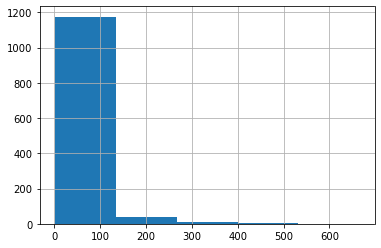

In [101]:
rest.reviews_date_diff.value_counts().hist(bins=5)

т.к. очень большая разница в датах отзывов может быть следствием ошибки ввода, заменим на среднюю величину

In [102]:
#найдём среднее исключив слишком большие цифры
reviews_diff_mean = int(rest[rest.reviews_date_diff < 150].reviews_date_diff.mean())
rest.reviews_date_diff.fillna(reviews_diff_mean, inplace=True)
#rest.reviews_date_diff = rest.reviews_date_diff.apply(lambda x: reviews_diff_mean if x>244 else x)

Заменим выбросы

In [103]:
IQR_outlier(rest, 'reviews_date_diff', True)
rest.reviews_date_diff.sort_values(ascending=False)

25-й перцентиль: 37.0 75-й перцентиль: 120.0, IQR: 83.0,  Границы выбросов: [-87.5, 244.5].


7990     3207.0
10997    3137.0
39997    3127.0
8356     3096.0
19438    3094.0
          ...  
21741       1.0
21735       1.0
21660       1.0
21657       1.0
38540       1.0
Name: reviews_date_diff, Length: 40000, dtype: float64

Далее обработаем стоимость (price_rance)

In [104]:
rest.price_range.value_counts(dropna=False)
# создадим словарь для замены символов на цифры
price_dict = {
    '$$ - $$$': 1.5,
    '$': 0,
    '$$$$': 3
}

In [105]:
rest.price_range = rest.price_range.replace(to_replace=price_dict)
rest.price_range.value_counts()

1.5    18412
0.0     6279
3.0     1423
Name: price_range, dtype: int64

Теперь можем найти среднюю цену по городам/ресторанам и заполнить пропуски. (Лучше по городам, т.к. если у одних ресторанов будут аналоги в других странах, то у других такого может и не быть)

In [106]:
rest_price = rest.copy()
price_group = rest_price.groupby(['city']).price_range.mean()
#price_city_dict = dict(round_of_rating(price_group.sort_values()))
price_city_dict = dict(round(price_group.sort_values(),1))
price_city_dict

{'Krakow': 1.0,
 'Oporto': 1.0,
 'Budapest': 1.1,
 'Edinburgh': 1.1,
 'Athens': 1.1,
 'Rome': 1.1,
 'Lisbon': 1.1,
 'Prague': 1.1,
 'Milan': 1.1,
 'Berlin': 1.1,
 'Dublin': 1.2,
 'Ljubljana': 1.2,
 'Barcelona': 1.2,
 'London': 1.2,
 'Warsaw': 1.2,
 'Helsinki': 1.2,
 'Bratislava': 1.3,
 'Amsterdam': 1.3,
 'Madrid': 1.3,
 'Vienna': 1.3,
 'Brussels': 1.3,
 'Hamburg': 1.3,
 'Lyon': 1.3,
 'Paris': 1.3,
 'Copenhagen': 1.4,
 'Munich': 1.4,
 'Stockholm': 1.4,
 'Oslo': 1.4,
 'Zurich': 1.4,
 'Luxembourg': 1.5,
 'Geneva': 1.6}

In [107]:
rest_price.price_range.fillna(rest_price.city, inplace=True)
rest_price.price_range = rest_price.price_range.replace(to_replace = price_city_dict)
rest_price.price_range.value_counts()

1.5    18474
0.0     6279
1.3     5123
1.1     3840
1.2     3188
3.0     1423
1.4     1220
1.0      297
1.6      156
Name: price_range, dtype: int64

Добавим столбец в основную df

In [108]:
rest.price_range = rest_price.price_range.copy()

Заполним пропуски в numbers_of_reviews. Сначала проверим какое среднее кол-во отзывов у ресторанов и заполним этими показателями пропуски

In [109]:
rest_number_reviews = rest.copy()
reviews_group = rest_number_reviews.groupby(['restaurant_id']).number_of_reviews.mean()
reviews_dict = dict(round(reviews_group))
rest_number_reviews.number_of_reviews.fillna(rest_number_reviews.restaurant_id, inplace=True)
rest_number_reviews.number_of_reviews = rest_number_reviews.number_of_reviews.replace(to_replace = reviews_dict)
rest_number_reviews.number_of_reviews.isna().value_counts()

False    39495
True       505
Name: number_of_reviews, dtype: int64

In [110]:
# осталось только 500 nan из 40000, заполним эти пропуски средним значением
number_reviews_mean = int(rest_number_reviews.number_of_reviews.mean())
rest_number_reviews.number_of_reviews.fillna(number_reviews_mean, inplace=True)

In [111]:
rest.number_of_reviews = rest_number_reviews.number_of_reviews.copy()


Добавим колонку с подсчётом ресторанов в городе

In [112]:
rest['rest_in_city']=rest.groupby(["city"])['restaurant_id'].transform('count')
rest.rest_in_city

0        4897
1         820
2        5757
3        2155
4         893
         ... 
39995    2133
39996    4897
39997     820
39998     727
39999    2133
Name: rest_in_city, Length: 40000, dtype: int64

In [113]:
rest.reviews_date_diff.sort_values(ascending=False)

7990     3207.0
10997    3137.0
39997    3127.0
8356     3096.0
19438    3094.0
          ...  
21741       1.0
21735       1.0
21660       1.0
21657       1.0
38540       1.0
Name: reviews_date_diff, Length: 40000, dtype: float64

In [114]:
rest_city = rest.copy()
#res = pd.DataFrame(mlb.fit_transform(rest.city, columns=))

#city_columns = rest_city.city.value_counts().keys()
#rest_mlb = mlb.fit_transform(rest_city.city, columns=city_columns)
#genre = mlb.inverse_transform(rest_mlb)
#rest_city_mlb = pd.DataFrame(mlb.fit(rest_city.city), columns=city_columns)

#mlb.fit_transform(rest_city.city).shape


city_dummies = pd.get_dummies(rest_city['city'])

rest_city = pd.concat([rest_city, city_dummies], axis=1)
rest_city.drop('city', axis=1, inplace=True)

In [115]:
rest = rest_city.copy()

In [116]:
rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 60 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   restaurant_id        40000 non-null  object 
 1   ranking              40000 non-null  float64
 2   rating               40000 non-null  float64
 3   price_range          40000 non-null  float64
 4   number_of_reviews    40000 non-null  float64
 5   reviews              40000 non-null  object 
 6   url_ta               40000 non-null  object 
 7   id_ta                40000 non-null  object 
 8   cuisine_count        40000 non-null  int64  
 9   Asian                40000 non-null  uint8  
 10  Bar                  40000 non-null  uint8  
 11  British              40000 non-null  uint8  
 12  Cafe                 40000 non-null  uint8  
 13  European             40000 non-null  uint8  
 14  Fast Food            40000 non-null  uint8  
 15  French               40000 non-null 

__Поработаем с сильно скоррелироваными признаками__

Vegan, Gluten Free, Vegetarian Friendly

In [117]:
#Vegan, gluten free, vegetarian
rest['GVV'] = 0
rest.loc[rest['Vegan Options'] == 1, 'GVV'] = 1
rest.loc[rest['Vegetarian Friendly'] == 1, 'GVV'] = 1
rest.loc[rest['Gluten Free Options'] == 1, 'GVV'] = 1

In [118]:
rest.drop(['Vegan Options', 'Vegetarian Friendly', 'Gluten Free Options'], axis=1, inplace=True)

Pizza & Italian

In [119]:
rest['it_pizza'] = 0
rest.loc[rest['Italian'] == 1, 'it_pizza'] = 1
rest.loc[rest['Pizza'] == 1, 'it_pizza'] = 1

In [120]:
rest.drop(['Italian', 'Pizza'], axis=1, inplace=True)

Проверим корреляцию

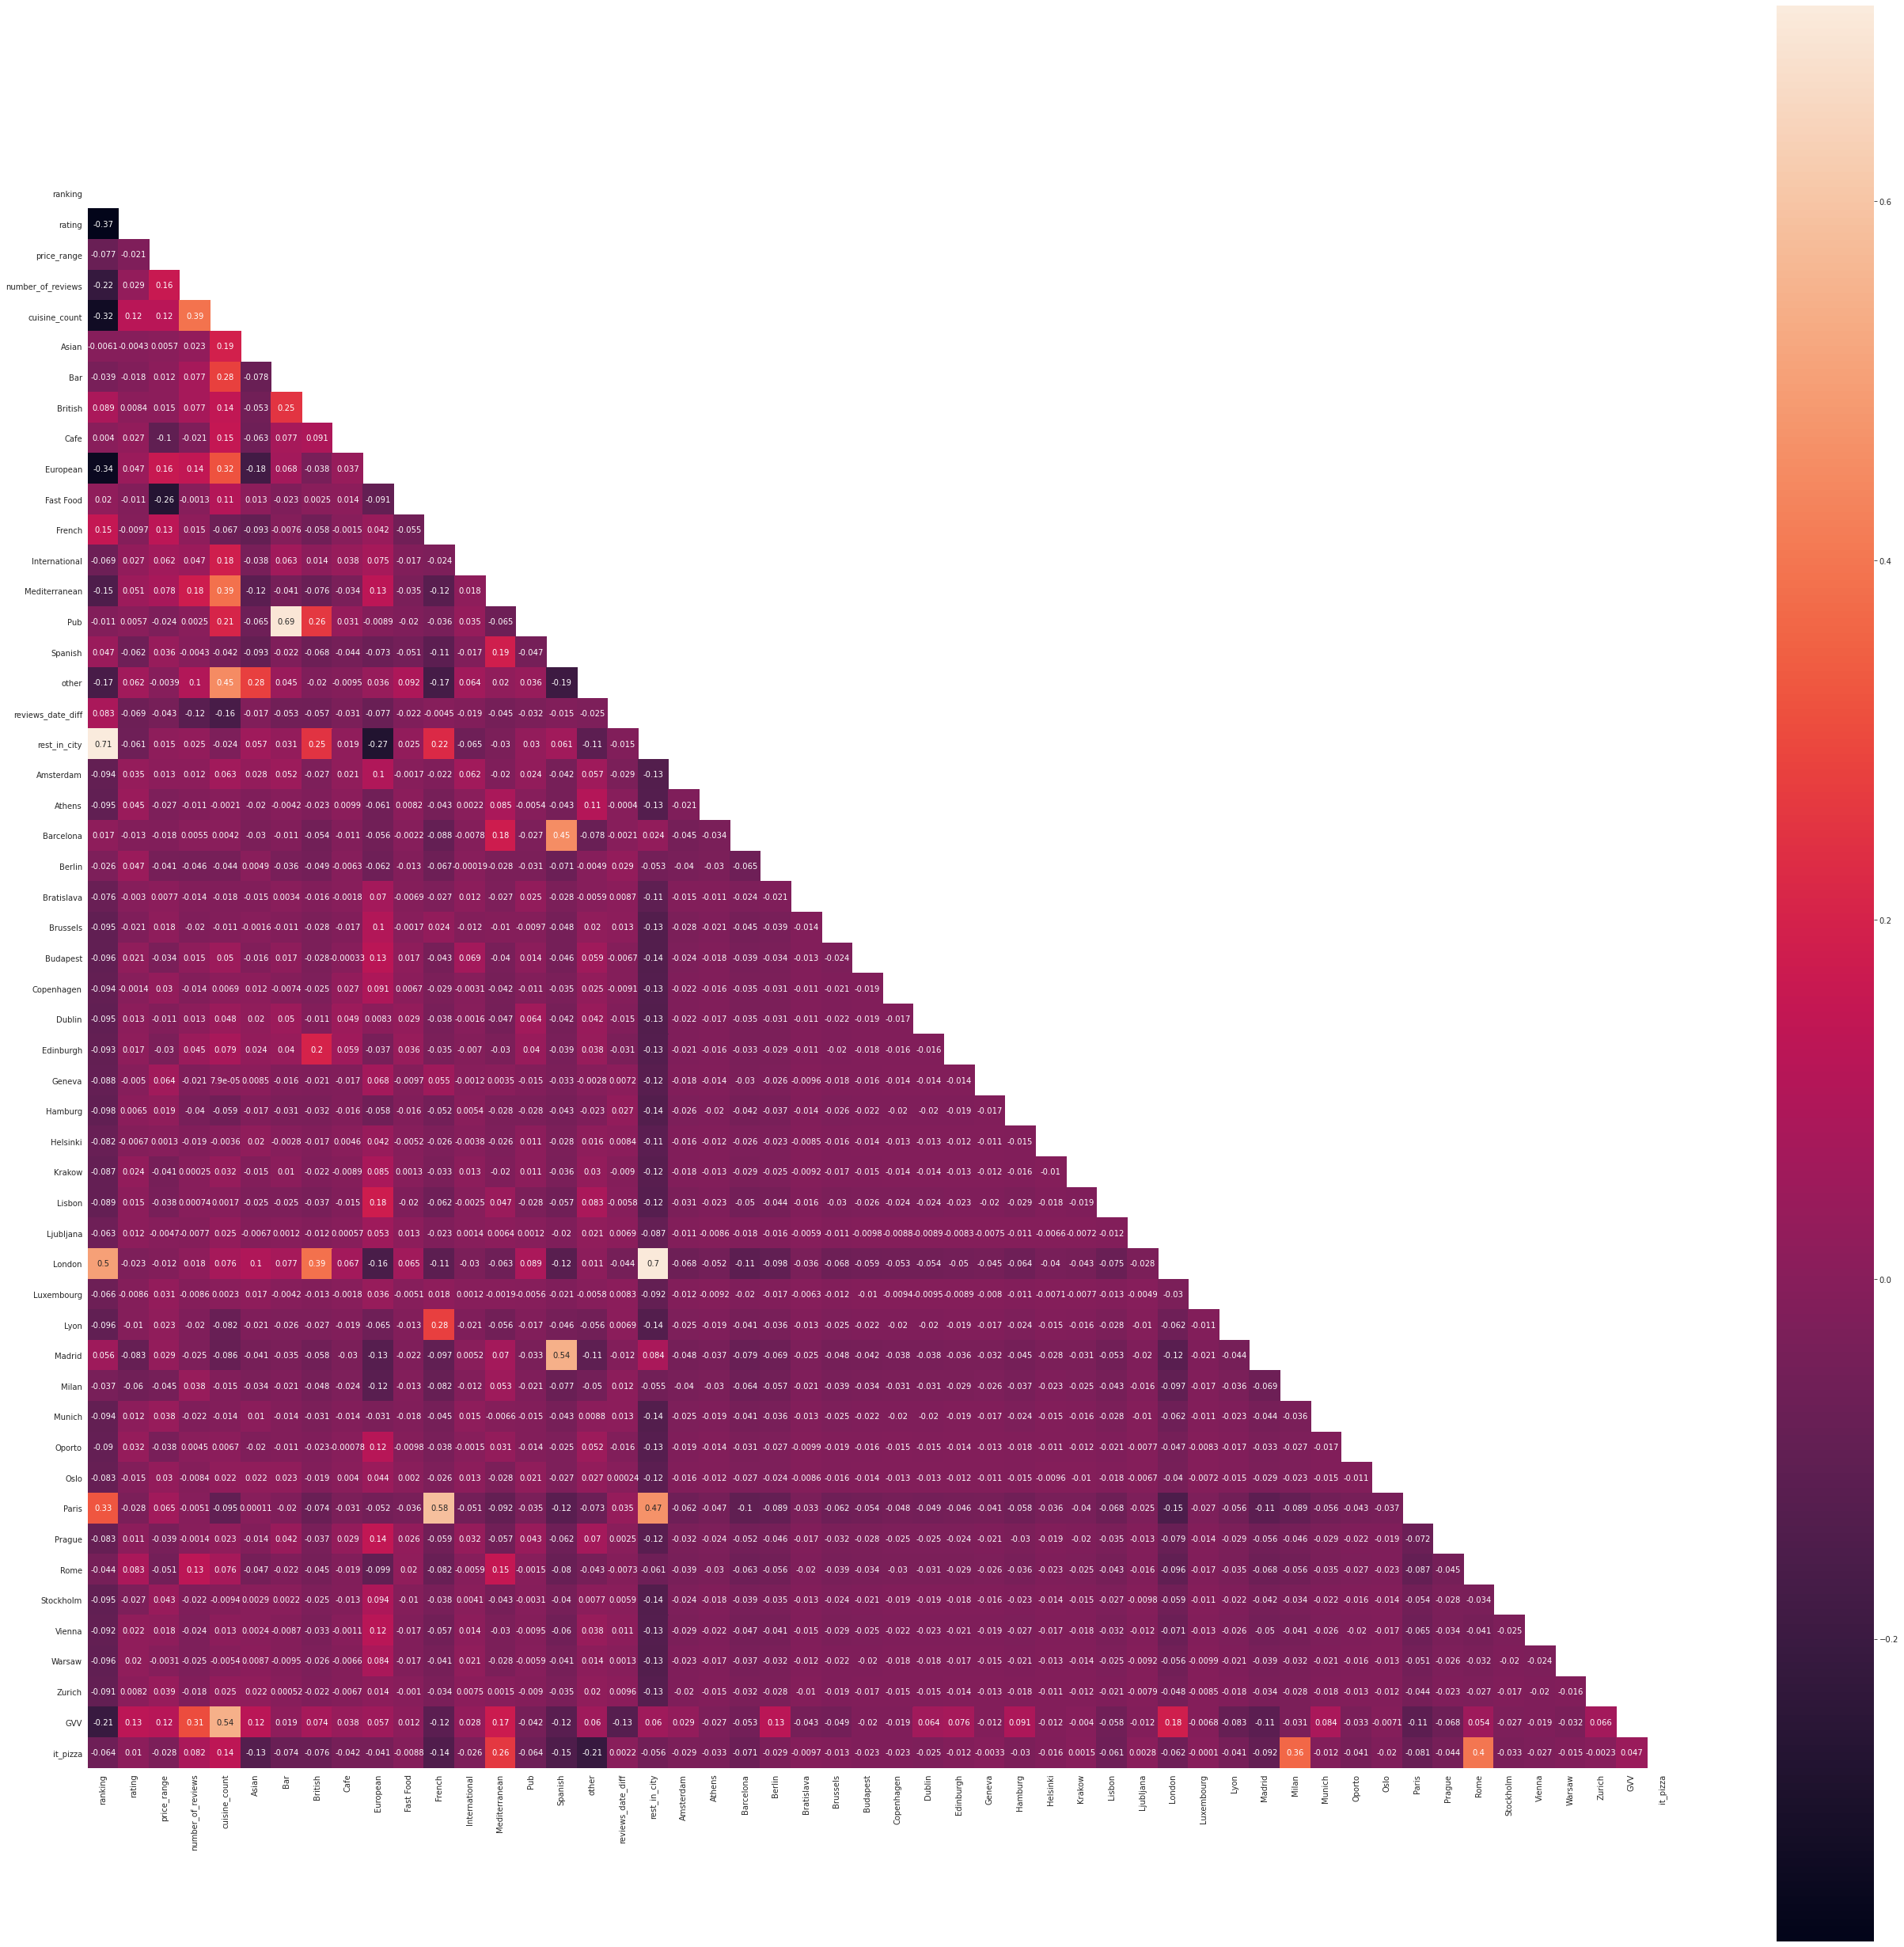

In [121]:
corr = rest.drop(['restaurant_id',
                      'reviews',
                      'url_ta', 'id_ta', 'reviews_date'],  axis=1).\
                dropna(axis=0).\
                corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(45, 45))
    ax = sns.heatmap(corr, mask=mask, annot=True, square=True)
plt.show()

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [131]:
test_rest = rest.copy()
object_col = ['reviews', 'url_ta', 'id_ta', 'reviews_date']
test_rest = test_rest.drop(axis=1, labels=object_col)



In [132]:
test_rest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 53 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   ranking            40000 non-null  float64
 2   rating             40000 non-null  float64
 3   price_range        40000 non-null  float64
 4   number_of_reviews  40000 non-null  float64
 5   cuisine_count      40000 non-null  int64  
 6   Asian              40000 non-null  uint8  
 7   Bar                40000 non-null  uint8  
 8   British            40000 non-null  uint8  
 9   Cafe               40000 non-null  uint8  
 10  European           40000 non-null  uint8  
 11  Fast Food          40000 non-null  uint8  
 12  French             40000 non-null  uint8  
 13  International      40000 non-null  uint8  
 14  Mediterranean      40000 non-null  uint8  
 15  Pub                40000 non-null  uint8  
 16  Spanish            400

In [133]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)

X = test_rest.drop(['restaurant_id', 'rating'], axis = 1)
y = test_rest['rating']

In [134]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [135]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [136]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [137]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [138]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.21833499999999995


In [130]:
# 0.2192065
# 0.217162
# 0.2178665
# 0.21904899999999997
# 0.21819899999999998
# 0.21655249999999995